In [1]:
%pip install matplotlib; torch; sahi; scikit-image


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os.path

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt

from sahi.slicing import slice_coco
from sahi.utils.file import load_json, save_json

In [ ]:
DATA_DIR = os.path.join("..", "data")

ANNOTATION_PATH = os.path.join(DATA_DIR, "coco_json_files/coco.json")
CORRECTED_ANNOTATION_PATH = os.path.join(DATA_DIR, "coco_json_files/coco_corrected.json")

IMAGE_DIR = os.path.join(DATA_DIR, "images")
SLICED_IMAGE_DIR = os.path.join(DATA_DIR, "images_sliced")

BBOX_VISUALIZATION_DIR = os.path.join(DATA_DIR, "bbox_visualization")

In [10]:
coco_dict = load_json(ANNOTATION_PATH)
[img.update({"file_name": img["file_name"].split("/")[-1]}) for img in coco_dict["images"]]
save_json(coco_dict, save_path=CORRECTED_ANNOTATION_PATH)

coco_dict

{'images': [{'width': 4096,
   'height': 2000,
   'id': 0,
   'file_name': '01BE01.bmp'}],
 'annotations': [{'id': 0,
   'image_id': 0,
   'category_id': 6,
   'segmentation': [],
   'bbox': [3243.732519135956,
    674.1576397397976,
    96.69150425145112,
    116.35757291276306],
   'ignore': 0,
   'iscrowd': 0,
   'area': 11250.788755982963},
  {'id': 1,
   'image_id': 0,
   'category_id': 6,
   'segmentation': [],
   'bbox': [2752.15197481034,
    1706.6478091354281,
    45.88749354306201,
    80.30311370035747],
   'ignore': 0,
   'iscrowd': 0,
   'area': 3684.9086114129277},
  {'id': 2,
   'image_id': 0,
   'category_id': 6,
   'segmentation': [],
   'bbox': [1529.1878991321566,
    557.4169134727985,
    45.887493543061424,
    37.693298267514876],
   'ignore': 0,
   'iscrowd': 0,
   'area': 1729.6509808672772},
  {'id': 3,
   'image_id': 0,
   'category_id': 6,
   'segmentation': [],
   'bbox': [1567.6792100432908,
    505.00420582112133,
    23.630943165701463,
    29.886192827

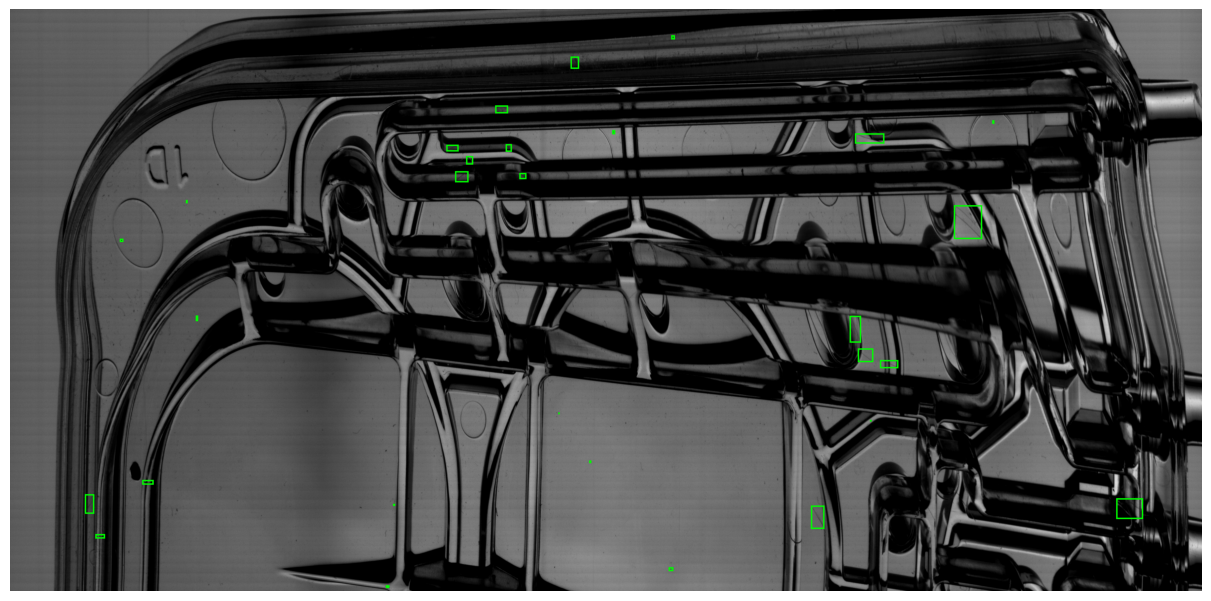

<Figure size 640x480 with 0 Axes>

In [ ]:
# Iterate over images in coco_dict
for img in coco_dict["images"]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 9), constrained_layout=True)

    # Load image in grayscale and convert to RGB
    mono_img = Image.open(os.path.join(IMAGE_DIR, img["file_name"])).convert("L")
    rgb_img = Image.merge("RGB", (mono_img, mono_img, mono_img))

    # Iterate over all annotations
    for ann_ind in range(len(coco_dict["annotations"])):
        if coco_dict["annotations"][ann_ind]["image_id"] == img["id"]:
            # Convert COCO bbox to PIL bbox
            xywh = coco_dict["annotations"][ann_ind]["bbox"]
            xyxy = [xywh[0], xywh[1], xywh[0] + xywh[2], xywh[1] + xywh[3]]

            # Draw bounding box on the image
            ImageDraw.Draw(rgb_img).rectangle(xyxy, width=5, outline="lime")

    ax.axis("off")
    ax.imshow(rgb_img)
    
    plt.show()

    # Save the figure to file
    fig.savefig(os.path.join(BBOX_VISUALIZATION_DIR, img["file_name"][:-4] + ".png"))

    # Clear and close the figure
    plt.clf()
    plt.close(fig)

In [14]:
coco_dict, coco_path = slice_coco(
    coco_annotation_file_path=CORRECTED_ANNOTATION_PATH,
    image_dir=IMAGE_DIR,
    output_coco_annotation_file_name="../sliced",
    ignore_negative_samples=False,
    output_dir=SLICED_IMAGE_DIR,
    slice_height=640,
    slice_width=640,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    min_area_ratio=0.1,
    verbose=False
)

indexing coco dataset annotations...


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


In [15]:
num_rows = len(set([img["file_name"].split("_")[-1] for img in coco_dict["images"]]))
num_cols = len(set([img["file_name"].split("_")[-2] for img in coco_dict["images"]]))
print(num_rows)
print(num_cols)

4
8


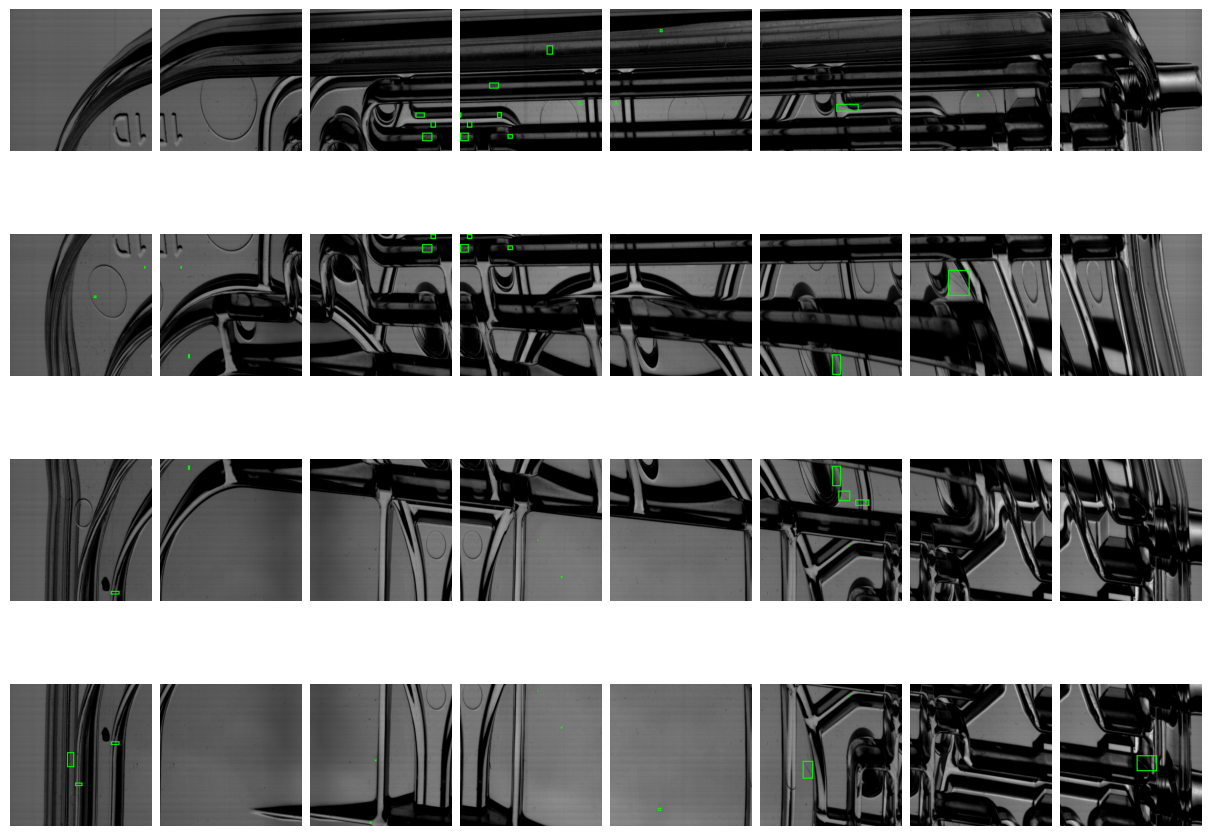

<Figure size 640x480 with 0 Axes>

In [20]:
for img in coco_dict["images"][::num_rows * num_cols]:
    img_idx = img["id"] - 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9), constrained_layout=True)
    # fig.tight_layout()
    # fig.subplots_adjust(wspace=0.1, hspace=0.1)

    for row_idx in range(num_rows):
        for col_idx in range(num_cols):

            # read image
            mono_img = Image.open(os.path.join(SLICED_IMAGE_DIR, coco_dict["images"][img_idx]["file_name"])).convert("L")
            rgb_img = Image.merge("RGB", (mono_img, mono_img, mono_img))

            # iterate over all annotations
            for ann_ind in range(len(coco_dict["annotations"])):

                # find annotations that belong the selected image
                if coco_dict["annotations"][ann_ind]["image_id"] == coco_dict["images"][img_idx]["id"]:
                    # convert coco bbox to pil bbox
                    xywh = coco_dict["annotations"][ann_ind]["bbox"]
                    xyxy = [xywh[0], xywh[1], xywh[0]+xywh[2], xywh[1]+xywh[3]]

                    # visualize bbox over image
                    ImageDraw.Draw(rgb_img).rectangle(xyxy, width=5, outline="lime")

            axes[row_idx, col_idx].imshow(rgb_img)
            axes[row_idx, col_idx].axis("off")

            img_idx += 1

    plt.show()

    fig.savefig(os.path.join(BBOX_VISUALIZATION_DIR, img["file_name"].split("_")[0] + "_sliced.png"))
    plt.clf()
    plt.close(fig)